# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([-0.03911897, -0.16320246, -0.00393724,  0.26004414]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.6374355702501995 -3.005400561675094


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [10]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(tf.multiply(actions_logits[:-1], actions_onehot[1:]), axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))    
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [15]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [16]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    memory.buffer.append([action, state, done])
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
state, reward, action

(array([ 0.052295  , -0.22862541, -0.1407575 ,  0.04487373]), 1.0, 0)

In [19]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            memory.buffer.append([action, state, done])
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            dones = np.array([each[2] for each in batch])
            
            # Calculate targetQs/nextQs
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
            Qs = np.max(actions_logits, axis=1)
            targetQs = Qs * (1 - dones.astype(float))
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions,
                                                                     model.states: states,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.9f}'.format(np.mean(loss_batch)),
              'Explore P: {:.9f}'.format(explore_p))
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn.ckpt')

Episode: 0 Total reward: 31.0 Average loss: 0.003211485 Explore P: 0.996935752
Episode: 1 Total reward: 19.0 Average loss: 0.008853490 Explore P: 0.995062354
Episode: 2 Total reward: 14.0 Average loss: 0.015009383 Explore P: 0.993684232
Episode: 3 Total reward: 17.0 Average loss: 0.028338371 Explore P: 0.992013389
Episode: 4 Total reward: 11.0 Average loss: 0.032855000 Explore P: 0.990933769
Episode: 5 Total reward: 23.0 Average loss: 0.050788432 Explore P: 0.988680214
Episode: 6 Total reward: 33.0 Average loss: 0.096434422 Explore P: 0.985455892
Episode: 7 Total reward: 28.0 Average loss: 0.239677623 Explore P: 0.982728436
Episode: 8 Total reward: 15.0 Average loss: 0.523685336 Explore P: 0.981270437
Episode: 9 Total reward: 23.0 Average loss: 1.034716010 Explore P: 0.979039082
Episode: 10 Total reward: 20.0 Average loss: 1.824410796 Explore P: 0.977102940
Episode: 11 Total reward: 40.0 Average loss: 3.001561403 Explore P: 0.973242255
Episode: 12 Total reward: 11.0 Average loss: 5.212

Episode: 97 Total reward: 21.0 Average loss: 16050677760.000000000 Explore P: 0.762804031
Episode: 98 Total reward: 26.0 Average loss: 22096011264.000000000 Explore P: 0.760849283
Episode: 99 Total reward: 16.0 Average loss: 26845016064.000000000 Explore P: 0.759648885
Episode: 100 Total reward: 14.0 Average loss: 31854002176.000000000 Explore P: 0.758600111
Episode: 101 Total reward: 46.0 Average loss: 39121264640.000000000 Explore P: 0.755164458
Episode: 102 Total reward: 69.0 Average loss: 53448572928.000000000 Explore P: 0.750040521
Episode: 103 Total reward: 33.0 Average loss: 67618217984.000000000 Explore P: 0.747602413
Episode: 104 Total reward: 26.0 Average loss: 73504047104.000000000 Explore P: 0.745687137
Episode: 105 Total reward: 22.0 Average loss: 81149190144.000000000 Explore P: 0.744070405
Episode: 106 Total reward: 49.0 Average loss: 84743479296.000000000 Explore P: 0.740482258
Episode: 107 Total reward: 45.0 Average loss: 84116111360.000000000 Explore P: 0.737202473
Ep

Episode: 186 Total reward: 200.0 Average loss: 687170004189184.000000000 Explore P: 0.379593940
Episode: 187 Total reward: 27.0 Average loss: 793984498663424.000000000 Explore P: 0.378597382
Episode: 188 Total reward: 91.0 Average loss: 775948723027968.000000000 Explore P: 0.375258362
Episode: 189 Total reward: 196.0 Average loss: 603043674456064.000000000 Explore P: 0.368169000
Episode: 190 Total reward: 195.0 Average loss: 339309764804608.000000000 Explore P: 0.361252361
Episode: 191 Total reward: 192.0 Average loss: 162327349428224.000000000 Explore P: 0.354572646
Episode: 192 Total reward: 200.0 Average loss: 162244704862208.000000000 Explore P: 0.347749651
Episode: 193 Total reward: 200.0 Average loss: 187357982621696.000000000 Explore P: 0.341061760
Episode: 194 Total reward: 200.0 Average loss: 222776816304128.000000000 Explore P: 0.334506298
Episode: 195 Total reward: 102.0 Average loss: 263114914267136.000000000 Explore P: 0.331213157
Episode: 196 Total reward: 200.0 Average l

Episode: 273 Total reward: 200.0 Average loss: 603673985024.000000000 Explore P: 0.078135948
Episode: 274 Total reward: 200.0 Average loss: 514443804672.000000000 Explore P: 0.076786766
Episode: 275 Total reward: 200.0 Average loss: 320349274112.000000000 Explore P: 0.075464299
Episode: 276 Total reward: 200.0 Average loss: 265210347520.000000000 Explore P: 0.074168019
Episode: 277 Total reward: 200.0 Average loss: 246463807488.000000000 Explore P: 0.072897407
Episode: 278 Total reward: 200.0 Average loss: 204614205440.000000000 Explore P: 0.071651955
Episode: 279 Total reward: 200.0 Average loss: 270584905728.000000000 Explore P: 0.070431165
Episode: 280 Total reward: 200.0 Average loss: 369022697472.000000000 Explore P: 0.069234547
Episode: 281 Total reward: 200.0 Average loss: 732372729856.000000000 Explore P: 0.068061625
Episode: 282 Total reward: 200.0 Average loss: 326766100480.000000000 Explore P: 0.066911928
Episode: 283 Total reward: 200.0 Average loss: 107677474816.000000000 

Episode: 360 Total reward: 156.0 Average loss: 46082495086592.000000000 Explore P: 0.026439795
Episode: 361 Total reward: 135.0 Average loss: 58621605969920.000000000 Explore P: 0.026219350
Episode: 362 Total reward: 131.0 Average loss: 77722558660608.000000000 Explore P: 0.026008262
Episode: 363 Total reward: 123.0 Average loss: 113041366581248.000000000 Explore P: 0.025812566
Episode: 364 Total reward: 112.0 Average loss: 221898109616128.000000000 Explore P: 0.025636453
Episode: 365 Total reward: 13.0 Average loss: 376962971336704.000000000 Explore P: 0.025616139
Episode: 366 Total reward: 13.0 Average loss: 471404738772992.000000000 Explore P: 0.025595851
Episode: 367 Total reward: 12.0 Average loss: 589324743606272.000000000 Explore P: 0.025577148
Episode: 368 Total reward: 16.0 Average loss: 688273341022208.000000000 Explore P: 0.025552244
Episode: 369 Total reward: 119.0 Average loss: 484896069910528.000000000 Explore P: 0.025368269
Episode: 370 Total reward: 182.0 Average loss: 

Episode: 447 Total reward: 200.0 Average loss: 47886586871808.000000000 Explore P: 0.014512291
Episode: 448 Total reward: 200.0 Average loss: 57247006720000.000000000 Explore P: 0.014422941
Episode: 449 Total reward: 200.0 Average loss: 77707081678848.000000000 Explore P: 0.014335361
Episode: 450 Total reward: 200.0 Average loss: 82950037176320.000000000 Explore P: 0.014249515
Episode: 451 Total reward: 200.0 Average loss: 76809039249408.000000000 Explore P: 0.014165369
Episode: 452 Total reward: 200.0 Average loss: 69281735770112.000000000 Explore P: 0.014082889
Episode: 453 Total reward: 200.0 Average loss: 63398247137280.000000000 Explore P: 0.014002043
Episode: 454 Total reward: 200.0 Average loss: 72280340168704.000000000 Explore P: 0.013922797
Episode: 455 Total reward: 200.0 Average loss: 81687685890048.000000000 Explore P: 0.013845121
Episode: 456 Total reward: 200.0 Average loss: 76702185160704.000000000 Explore P: 0.013768982
Episode: 457 Total reward: 200.0 Average loss: 624

Episode: 534 Total reward: 200.0 Average loss: 65724978561024.000000000 Explore P: 0.010791999
Episode: 535 Total reward: 200.0 Average loss: 61662287626240.000000000 Explore P: 0.010776316
Episode: 536 Total reward: 200.0 Average loss: 64349234266112.000000000 Explore P: 0.010760944
Episode: 537 Total reward: 200.0 Average loss: 68029580836864.000000000 Explore P: 0.010745877
Episode: 538 Total reward: 200.0 Average loss: 61763781394432.000000000 Explore P: 0.010731107
Episode: 539 Total reward: 200.0 Average loss: 60821996568576.000000000 Explore P: 0.010716630
Episode: 540 Total reward: 200.0 Average loss: 67496816148480.000000000 Explore P: 0.010702440
Episode: 541 Total reward: 200.0 Average loss: 75097545113600.000000000 Explore P: 0.010688531
Episode: 542 Total reward: 200.0 Average loss: 75541638021120.000000000 Explore P: 0.010674897
Episode: 543 Total reward: 200.0 Average loss: 75480107581440.000000000 Explore P: 0.010661533
Episode: 544 Total reward: 200.0 Average loss: 669

Episode: 621 Total reward: 200.0 Average loss: 62676403224576.000000000 Explore P: 0.010139012
Episode: 622 Total reward: 200.0 Average loss: 56071100039168.000000000 Explore P: 0.010136259
Episode: 623 Total reward: 200.0 Average loss: 61662887411712.000000000 Explore P: 0.010133561
Episode: 624 Total reward: 200.0 Average loss: 73212482289664.000000000 Explore P: 0.010130917
Episode: 625 Total reward: 200.0 Average loss: 84257494007808.000000000 Explore P: 0.010128324
Episode: 626 Total reward: 200.0 Average loss: 75809813430272.000000000 Explore P: 0.010125783
Episode: 627 Total reward: 200.0 Average loss: 75793162043392.000000000 Explore P: 0.010123293
Episode: 628 Total reward: 200.0 Average loss: 77060487774208.000000000 Explore P: 0.010120851
Episode: 629 Total reward: 200.0 Average loss: 60606862327808.000000000 Explore P: 0.010118458
Episode: 630 Total reward: 200.0 Average loss: 53280466010112.000000000 Explore P: 0.010116113
Episode: 631 Total reward: 200.0 Average loss: 703

Episode: 708 Total reward: 200.0 Average loss: 86009052135424.000000000 Explore P: 0.010024417
Episode: 709 Total reward: 200.0 Average loss: 79325042835456.000000000 Explore P: 0.010023933
Episode: 710 Total reward: 200.0 Average loss: 70219993186304.000000000 Explore P: 0.010023459
Episode: 711 Total reward: 200.0 Average loss: 68926805377024.000000000 Explore P: 0.010022995
Episode: 712 Total reward: 200.0 Average loss: 75448415420416.000000000 Explore P: 0.010022539
Episode: 713 Total reward: 200.0 Average loss: 73363787612160.000000000 Explore P: 0.010022093
Episode: 714 Total reward: 200.0 Average loss: 79322912129024.000000000 Explore P: 0.010021656
Episode: 715 Total reward: 200.0 Average loss: 83916438372352.000000000 Explore P: 0.010021227
Episode: 716 Total reward: 200.0 Average loss: 71566629011456.000000000 Explore P: 0.010020806
Episode: 717 Total reward: 200.0 Average loss: 61412911087616.000000000 Explore P: 0.010020394
Episode: 718 Total reward: 200.0 Average loss: 659

Episode: 795 Total reward: 200.0 Average loss: 77715654836224.000000000 Explore P: 0.010004286
Episode: 796 Total reward: 200.0 Average loss: 73029098930176.000000000 Explore P: 0.010004201
Episode: 797 Total reward: 200.0 Average loss: 55349298069504.000000000 Explore P: 0.010004118
Episode: 798 Total reward: 200.0 Average loss: 51366923862016.000000000 Explore P: 0.010004036
Episode: 799 Total reward: 200.0 Average loss: 49519328755712.000000000 Explore P: 0.010003956
Episode: 800 Total reward: 200.0 Average loss: 55152589406208.000000000 Explore P: 0.010003878
Episode: 801 Total reward: 200.0 Average loss: 61298695995392.000000000 Explore P: 0.010003801
Episode: 802 Total reward: 200.0 Average loss: 67051557224448.000000000 Explore P: 0.010003726
Episode: 803 Total reward: 200.0 Average loss: 69714407587840.000000000 Explore P: 0.010003652
Episode: 804 Total reward: 200.0 Average loss: 68167971897344.000000000 Explore P: 0.010003580
Episode: 805 Total reward: 200.0 Average loss: 711

Episode: 882 Total reward: 200.0 Average loss: 67832352079872.000000000 Explore P: 0.010000752
Episode: 883 Total reward: 200.0 Average loss: 48895396675584.000000000 Explore P: 0.010000737
Episode: 884 Total reward: 200.0 Average loss: 50351747104768.000000000 Explore P: 0.010000723
Episode: 885 Total reward: 200.0 Average loss: 65716971634688.000000000 Explore P: 0.010000708
Episode: 886 Total reward: 200.0 Average loss: 61229783580672.000000000 Explore P: 0.010000694
Episode: 887 Total reward: 200.0 Average loss: 54585792135168.000000000 Explore P: 0.010000681
Episode: 888 Total reward: 200.0 Average loss: 56328022130688.000000000 Explore P: 0.010000667
Episode: 889 Total reward: 200.0 Average loss: 60409188974592.000000000 Explore P: 0.010000654
Episode: 890 Total reward: 200.0 Average loss: 71871345197056.000000000 Explore P: 0.010000641
Episode: 891 Total reward: 200.0 Average loss: 66770111037440.000000000 Explore P: 0.010000628
Episode: 892 Total reward: 200.0 Average loss: 558

Episode: 969 Total reward: 200.0 Average loss: 69222952599552.000000000 Explore P: 0.010000132
Episode: 970 Total reward: 200.0 Average loss: 80308691009536.000000000 Explore P: 0.010000129
Episode: 971 Total reward: 200.0 Average loss: 86420622409728.000000000 Explore P: 0.010000127
Episode: 972 Total reward: 200.0 Average loss: 84608934739968.000000000 Explore P: 0.010000124
Episode: 973 Total reward: 200.0 Average loss: 69150407917568.000000000 Explore P: 0.010000122
Episode: 974 Total reward: 200.0 Average loss: 51375576711168.000000000 Explore P: 0.010000119
Episode: 975 Total reward: 200.0 Average loss: 42427847016448.000000000 Explore P: 0.010000117
Episode: 976 Total reward: 200.0 Average loss: 53172886306816.000000000 Explore P: 0.010000115
Episode: 977 Total reward: 200.0 Average loss: 76676415356928.000000000 Explore P: 0.010000113
Episode: 978 Total reward: 200.0 Average loss: 90728910815232.000000000 Explore P: 0.010000110
Episode: 979 Total reward: 200.0 Average loss: 741

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

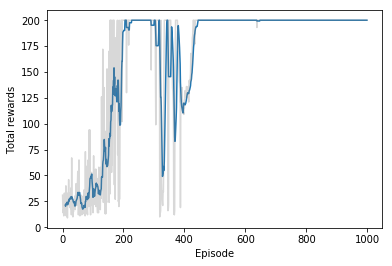

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

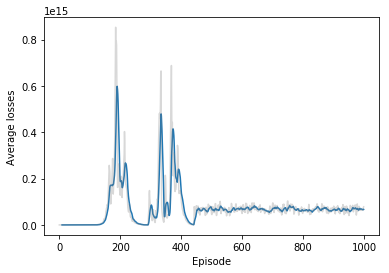

In [22]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-qn.ckpt')    
#     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 242.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.